In [33]:
import os
from openai import OpenAI
import docx
import pdfplumber
import subprocess
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState, START, END, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langsmith import traceable

#ReWOO Imports
from typing import List
from typing_extensions import TypedDict, Dict, Any
import re
from langchain_core.prompts import ChatPromptTemplate

In [17]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "agent_course"

In [26]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
llm = ChatOpenAI(model="gpt-4o-mini")

@tool
@traceable(name="Extract CV Tool")
def extract_cv_text(file_path: str)-> str:

    """ Extracts the text content from a CV file in PDF, DOCX, or DOC format. The CV should be inside 
            the same folder that this notebook is in.

        Args:
            file_path (str): The local file path to the CV document.

        returns:
            str: The extracted plain text fron the CV, or an error message if the format is unsupported
                    or cannot be read.
    """

    ext = os.path.splitext(file_path)[-1].lower()

    if ".docx" in ext:
        try:
            doc = docx.Document(file_path)
            text = [para.text for para in doc.paragraphs]
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading the .doc file: {e}"

    elif ".pdf" in ext:
        try:
            text=[]
            with pdfplumber.open(file_path) as pdf:
                for page in pdf.pages:
                    page_text=page.extract_text()
                    if page_text:
                        text.append(page_text)
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading the .pdf file: {e}"

    elif ".doc" in ext:
        try:
            
            temp_docx = file_path + ".temp.docx"
            subprocess.run(['soffice', '--headless', '--convert-to', 'docx', '--outdir', os.path.dirname(file_path), file_path], check=True)
            
            doc = docx.Document(os.path.splitext(file_path)[0] + ".docx")
            text = [para.text for para in doc.paragraphs]
            
            os.remove(os.path.splitext(file_path)[0] + ".docx")
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading .doc file: {e}"
    
    else:
        return "Unsupported file format! Please use .pdf, .docx, or .doc."

@tool
@traceable(name="Job Posting Extractor")
def job_posting_tool(job_link: str)-> str:

    """Extracts structured information from a job posting at the provided URL.

    Args:
        job_link (str): The URL of the job posting.

    Returns:
        str: A structured summary of the job posting's key details.
    
    """

    completion = client.chat.completions.create(
        model="gpt-4o-search-preview",
        web_search_options={
            "search_context_size": "medium",
        },
        messages=[
            {
                "role": "user",
                "content": """
                You are a helpful tool that visits the following job posting and carefully read its contents.  
                Summarize the key details in a clear and concise format, including:
                Visit the provided job posting link, read it thoroughly, and extract and summarize all key information. Include:
                - Job title
                - Company name
                - Location
                - Employment type (full-time, part-time, contract, etc.)
                - Salary or compensation (if available)
                - Required qualifications/skills
                - Primary responsibilities
                - Benefits offered
                - Application instructions
                - Posting date (if available)

                Format
                - Respond with a clear, structured bullet-point list.
                - Use exact factual information from the posting, no rewording beyond making it concise.
                - If the posting is missing, inaccessible, or contains no job details, respond with:
                "Job posting unavailable or contains no job details."

                Do's 
                - Ensure all extracted details are accurate and directly taken from the posting.
                - Keep descriptions short, professional, and easy to scan.
                - Use consistent formatting for all fields (e.g., “Job Title: …”).  
                Don'ts
                - Do not include filler language, speculation, or personal opinions.
                - Do not rewrite or interpret details—only report factual information from the posting.
                """,
            },
            {
                "role": "system",
                "content": f"Visit this job posting and extract details:\n{job_link}"
            }
        ],
    )
    return completion.choices[0].message.content
            
tools = [job_posting_tool, extract_cv_text]
tool_node = ToolNode(tools=tools)

llm_with_tools = llm.bind_tools(tools)

sys_msg = SystemMessage(
    content=""" You are an expert career assistant that helps the user with questions related to jobs, careers, and applications.

            Your key capabilities:
            - You have access to the user's CV and can read its contents using the `extract_cv_text` tool.
            - You can look up and extract details from job postings using the `job_posting_tool`.
            - You can compare the user's CV against one or more job postings to determine suitability and provide tailored advice.
            - You can suggest improvements to the CV for better alignment with target roles.

            When answering:
            1. First, think step-by-step about the user's request.
            2. If the task requires reading the CV, call the CV extraction tool before answering.
            3. If the task involves evaluating job postings, call the job posting tool to gather accurate information before answering.
            4. Compare and reason about the information before providing your final response.

            Response format:
            - Be clear, concise, and structured with bullet points or numbered lists.
            - Use section headers when possible (e.g., "Strengths", "Weaknesses", "Recommendations").
            - Support your statements with evidence from the CV or job postings.
            - Avoid vague language—be specific and factual.

            Constraints:
            - Do not invent or guess details about the user's experience or job postings.
            - Only use information available in the CV, job postings, or provided context.
            - Keep your tone professional, friendly, and supportive.
"""
)

@traceable(name="Assistant Node")
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [27]:
graph = StateGraph(MessagesState)
graph.add_node("assistant", assistant)
graph.add_node("tools", tool_node)
graph.add_edge(START, "assistant")
graph.add_conditional_edges("assistant", tools_condition)
graph.add_edge("tools", "assistant")
react_graph = graph.compile()

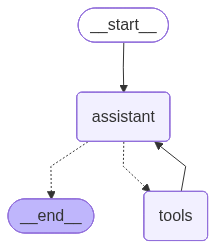

In [28]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [29]:
messages = [HumanMessage(content="""
        Can you take a look at my CV ath the location 'cv-template2.pdf'  and these 3 job applications and tell me whichone is the most suitable for my expiriance: 
        
        'https://www.indeed.com/viewjob?jk=247e94f9a28c544f&tk=1isdf5na1h72t810&from=serp&vjs=3',
        'https://www.indeed.com/viewjob?jk=744686732444f370&tk=1isns1midj72r8b4&from=serp&vjs=3',
        'https://www.indeed.com/viewjob?jk=01e2f371f220e42a&tk=1isns1midj72r8b4&from=serp&vjs=3'
        
        """)]

In [31]:
result = react_graph.invoke({"messages": messages})

In [32]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================


        Can you take a look at my CV ath the location 'cv-template2.pdf'  and these 3 job applications and tell me whichone is the most suitable for my expiriance: 

        'https://www.indeed.com/viewjob?jk=247e94f9a28c544f&tk=1isdf5na1h72t810&from=serp&vjs=3',
        'https://www.indeed.com/viewjob?jk=744686732444f370&tk=1isns1midj72r8b4&from=serp&vjs=3',
        'https://www.indeed.com/viewjob?jk=01e2f371f220e42a&tk=1isns1midj72r8b4&from=serp&vjs=3'

        
================================== Ai Message ==================================
Tool Calls:
  extract_cv_text (call_mY0BHdqFf9zWfizi5MHXRp9c)
 Call ID: call_mY0BHdqFf9zWfizi5MHXRp9c
  Args:
    file_path: cv-template2.pdf
  job_posting_tool (call_0Mj0TvaLWeOOUQDt2JothIVq)
 Call ID: call_0Mj0TvaLWeOOUQDt2JothIVq
  Args:
    job_link: https://www.indeed.com/viewjob?jk=247e94f9a28c544f&tk=1isdf5na1h72t810&from=serp&vjs=3
  job_posting_tool (call_

In [ ]:
messages = [HumanMessage(content="""
        Can you take a look at my CV ath the location 'cv-template2.pdf'  and these 3 job applications and tell me whichone is the most suitable for my expiriance: 
        
        'https://www.indeed.com/viewjob?jk=247e94f9a28c544f&tk=1isdf5na1h72t810&from=serp&vjs=3',
        'https://www.indeed.com/viewjob?jk=744686732444f370&tk=1isns1midj72r8b4&from=serp&vjs=3',
        'https://www.indeed.com/viewjob?jk=01e2f371f220e42a&tk=1isns1midj72r8b4&from=serp&vjs=3'
        
        """)]

In [49]:
memory=MemorySaver()
config = {"configurable": {"thread_id": "1"}}
react_graph_memory = graph.compile(checkpointer=memory)

In [50]:
resut = react_graph_memory.invoke({"messages": messages}, config)

In [51]:
for m in resut['messages']:
    m.pretty_print()

================================ Human Message =================================


        Can you take a look at my CV ath the location 'cv-template2.pdf'  and these 3 job applications and tell me whichone is the most suitable for my expiriance: 

        'https://www.indeed.com/viewjob?jk=247e94f9a28c544f&tk=1isdf5na1h72t810&from=serp&vjs=3',
        'https://www.indeed.com/viewjob?jk=744686732444f370&tk=1isns1midj72r8b4&from=serp&vjs=3',
        'https://www.indeed.com/viewjob?jk=01e2f371f220e42a&tk=1isns1midj72r8b4&from=serp&vjs=3'

        
================================== Ai Message ==================================
Tool Calls:
  extract_cv_text (call_LWFAx2H61Zu2JOyww1QVDxTu)
 Call ID: call_LWFAx2H61Zu2JOyww1QVDxTu
  Args:
    file_path: cv-template2.pdf
  job_posting_tool (call_idvrfAsO2rLcm12bBH68fcxF)
 Call ID: call_idvrfAsO2rLcm12bBH68fcxF
  Args:
    job_link: https://www.indeed.com/viewjob?jk=247e94f9a28c544f&tk=1isdf5na1h72t810&from=serp&vjs=3
  job_posting_tool (call_

In [52]:
messages = [HumanMessage(content="""
        For which job i am least suitable?
        """)]
result = react_graph_memory.invoke({"messages": messages}, config)

for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================


        Can you take a look at my CV ath the location 'cv-template2.pdf'  and these 3 job applications and tell me whichone is the most suitable for my expiriance: 

        'https://www.indeed.com/viewjob?jk=247e94f9a28c544f&tk=1isdf5na1h72t810&from=serp&vjs=3',
        'https://www.indeed.com/viewjob?jk=744686732444f370&tk=1isns1midj72r8b4&from=serp&vjs=3',
        'https://www.indeed.com/viewjob?jk=01e2f371f220e42a&tk=1isns1midj72r8b4&from=serp&vjs=3'

        
================================== Ai Message ==================================
Tool Calls:
  extract_cv_text (call_LWFAx2H61Zu2JOyww1QVDxTu)
 Call ID: call_LWFAx2H61Zu2JOyww1QVDxTu
  Args:
    file_path: cv-template2.pdf
  job_posting_tool (call_idvrfAsO2rLcm12bBH68fcxF)
 Call ID: call_idvrfAsO2rLcm12bBH68fcxF
  Args:
    job_link: https://www.indeed.com/viewjob?jk=247e94f9a28c544f&tk=1isdf5na1h72t810&from=serp&vjs=3
  job_posting_tool (call_